In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pdb
import glob
import matplotlib.ticker as ticker
from metpy.units import units as u
import metpy.constants as const
from matplotlib.gridspec import GridSpec
import xarray as xr
import sys
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.units import units as u
import matplotlib.transforms as mtransforms
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from PyTEMDiags import sph_zonal_averager

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
import climate_toolbox as ctb
import artist_utils as au
print('done')

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE = 9
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)

done


In [2]:
# =====================================
# ====== read IC data =================

ic_dir = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_ens_ics'
U, T = [], []

lat = np.linspace(-90, 90, 181)
ens = [1, 3, 5]

for i in range(3):
    print('reading LV ens0{}...'.format(ens[i]))
    dat = xr.open_dataset(glob.glob('{}/*pert0{}*.nc'.format(ic_dir, ens[i]))[0])
    dat = dat.assign_coords(time = ctb.time2day(dat['time'])).mean('time')
    
    if(i == 0):
        print('building zonal averager...')
        lev, datlat = dat['lev'], dat['lat']
        zm = sph_zonal_averager(dat['lat'], lat, L=70, debug=False)
        zm.sph_compute_matrices()
     
    print('taking LV zonal means...')
    T.append(zm.sph_zonal_mean(dat['T'].T).T)
    U.append(zm.sph_zonal_mean(dat['U'].T).T)

print('done')

reading LV ens01...
building zonal averager...
taking LV zonal means...
reading LV ens03...
taking LV zonal means...
reading LV ens05...
taking LV zonal means...
done


In [3]:
# ===========================================
# ============ compute V(z) =================

Vz = []

for i in range(5):
    datf = '/global/cfs/cdirs/m4014/data/HSW/outputs/release_030123/netcdf/low_var_ens/ens0{0}/HSW_SAI_ne16pg2_L72_1200day_90delay__ens0{0}.eam.h2.0001-01-01-00000.nc'.format(i+1)
    dat  = xr.open_dataset(datf)
    dat = dat.isel(time=0)
    
    if(i == 0):
        print('building zonal averager...')
        zm = sph_zonal_averager(dat['lat'], lat, L=70, debug=False)
        zm.sph_compute_matrices()
     
    print('taking Z3 zonal means...')
    Z = 1/1000 * (zm.sph_zonal_mean(dat['Z3'].T).T).sel(lat=15, method='nearest')
    
    print('computing V(z)...')
    Vz.append(np.exp(-0.5 * (Z - 18)**2 / 1.5**2))

building zonal averager...
taking Z3 zonal means...
computing V(z)...
taking Z3 zonal means...
computing V(z)...
taking Z3 zonal means...
computing V(z)...
taking Z3 zonal means...
computing V(z)...
taking Z3 zonal means...
computing V(z)...


/tmp/ipykernel_504767/2162957072.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


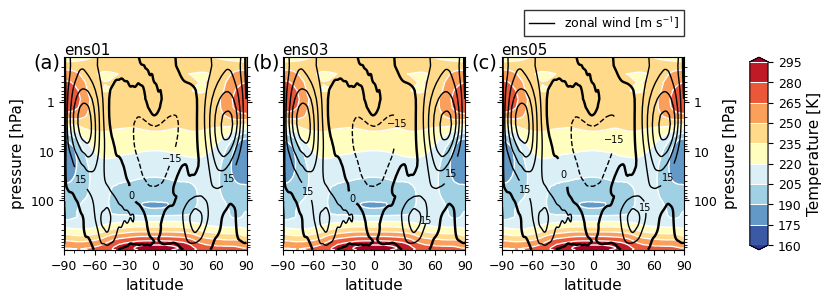

In [4]:
# =====================================
# ======= make figure =================

fig = plt.figure(figsize=(8, 2.5))
gs  = GridSpec(1, 3, wspace=0.2, hspace=0.15)

X, Y = np.meshgrid(lat, lev)

Tlev = np.arange(160, 310, 15)
Ulev = np.arange(-30, 75, 15)
Ulev = Ulev[Ulev !=0]

Tcmap='RdYlBu_r'
Tlw = 1
Tcolor = 'w'

Ukcolor = 'k'
Ucolor = 'k'
Ulw = 1
zero_line_fac = 1.75

latlim = 90
lat_ticks = [-90, -60, -30, 0, 30, 60, 90]

# =====================================

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax  = [ax1, ax2, ax3]

Ucf_labels   = [[[-74.2, 46.45], [73.9, 44.184], [16.6, 9.31]], 
                [[-65, 62.8], [76.2, 32.68], [57.4, 256.33], [27.8, 0.505]], 
                [[-66.3, 56.99], [73.9, 36.267], [53.1, 140.78], [21.5, 6.251]]]
Ucf_labels_0 = [[[-18.9, 59.72]], [[-16.8, 73.014]], [[-28.87, 28.212]]]

for i in range(3):
    Tcf = ax[i].contourf(X, Y, T[i], levels=Tlev, cmap=Tcmap, extend='both')
    ax[i].contour(X, Y, T[i], levels=Tlev, colors=Tcolor, linewidths=Tlw)
    Ucf   = ax[i].contour(X, Y, U[i], levels=Ulev, colors=Ucolor, linewidths=Ulw)
    Ucf_0 = ax[i].contour(X, Y, U[i], levels=[0], colors=Ucolor, linewidths=Ulw*zero_line_fac)
    
    labs   = ax[i].clabel(Ucf, inline=True, fontsize=SMALL_SIZE-2, manual=Ucf_labels[i][:-1], inline_spacing=1)
    labneg = ax[i].clabel(Ucf, inline=True, fontsize=SMALL_SIZE-2, manual=[Ucf_labels[i][-1]], inline_spacing=-7)
    lab0   = ax[i].clabel(Ucf_0, inline=True, fontsize=SMALL_SIZE-2, manual=Ucf_labels_0[i], inline_spacing=3)
    for lab in labs+labneg+lab0:
        lab.set_rotation(0)

    ax[i].set_xlabel('latitude')
    ax[i].set_xticks(lat_ticks)
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))
    ax[i].invert_yaxis()
    ax[i].set_yscale('log')
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax[i].set_xlim([-latlim, latlim])
    if(i == 0):
        ax[i].set_ylabel('pressure [hPa]')
        ax[i].tick_params(left=True, right=True, labelleft=True, labelright=False, which='both')
    if(i == 1):
        ax[i].tick_params(left=True, right=True, labelleft=False, labelright=False, which='both')
    if(i == 2):
        ax[i].yaxis.tick_right()
        ax[i].set_ylabel('pressure [hPa]')
        ax[i].yaxis.set_label_position("right")
        ax[i].tick_params(left=True, right=True, labelleft=False, labelright=True, which='both')
        
    # ------ overplot vertical injection profile
    #axvz = ax[i].twiny()
    #axvz.plot(Vz[i], lev, '-m')
    #axvz.set_xlim([-(15-(-90))*2/(90-15), 2])

ax3.plot([0], [0], 'k-', lw=Ulw, label=r'zonal wind [m s$^{-1}$]')
leg = ax3.legend(loc='upper right', bbox_to_anchor=(1.035, 1.28), 
                 fancybox=False, shadow=False, frameon=True)
leg.get_frame().set_edgecolor('k')

# ===============================

axins = inset_axes(ax3,
                   width="10%",
                   height="100%",
                   loc='upper left',
                   bbox_to_anchor=(1.36, 0, 1, 1),
                   bbox_transform=ax3.transAxes,
                   borderpad=0)
cbar = fig.colorbar(Tcf, cax=axins, orientation='vertical', pad=100, extendfrac=0.025)
cbar.set_label(r'Temperature [K]')
for k in range(len(Tlev)):
    axins.axhline(Tlev[k], color='w', lw=0.75)

axlabs = ['(a)', '(b)', '(c)']
for i in range(len(ax)):
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax[i].text(-0.015, 0.87, axlabs[i], transform=ax[i].transAxes + trans,
               fontsize=BIGGER_SIZE, va='bottom', fontfamily='sans-serif')
    
axlabs = ['ens01', 'ens03', 'ens05']
for i in range(len(ax)):
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax[i].text(0.15, 0.95, axlabs[i], transform=ax[i].transAxes + trans,
               fontsize=MEDIUM_SIZE, va='bottom', fontfamily='sans-serif')

plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig('figs/ensemble_ics_LV.pdf', dpi=300, bbox_inches='tight')
plt.show()